# Project Kojak - Weeks 09 - 12

## Test of Nonnegative Matrix Factorization (NMF)
(Jupyter Notebook 3 of 4)

### This notebook.

This notebook tries out the NMF on a small group example of four speakers/users. Mel cepstrum coeffiecients (MFCC) and PCA decomposition of the speaker dictionaries was also attempted but neither was successful.

In [572]:
import numpy as np
import glob

import pyaudio 
import wave
import soundfile as sf

import librosa, librosa.display
from scipy.fftpack import fft
from scipy import signal
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt

In [624]:
import Speech_Analysis  # custom module, facilitating notebook reloads
import importlib
importlib.reload(Speech_Analysis)
from Speech_Analysis import get_wavfiles, log_spectrogram, play_nstaudio
from Speech_Analysis import nmf_decomp

### Define an initial set of four diverse speakers: 2 men, 2 women from different regions ###

In [89]:
WBASE = r'data/TRAIN/'   # common base directory for all data

wavTrain = []

WREGION = 'DR1'          # Speaker A
WSPEAKER = 'MRCG0'
wavTrain.append(get_wavfiles(WBASE, WREGION, WSPEAKER))
WREGION = 'DR2'          # Speaker B
WSPEAKER = 'FCAJ0'
wavTrain.append(get_wavfiles(WBASE, WREGION, WSPEAKER))
WREGION = 'DR4'          # Speaker C
WSPEAKER = 'FLHD0'
wavTrain.append(get_wavfiles(WBASE, WREGION, WSPEAKER))
WREGION = 'DR6'          # Speaker D
WSPEAKER = 'MTJU0'
wavTrain.append(get_wavfiles(WBASE, WREGION, WSPEAKER))

In [90]:
# Test one audio file out at a time #
wav, srate = sf.read(wavTrain[3][3])
play_nstaudio(wav, srate)

In [823]:
wavTrain

[['data/TRAIN/DR1/MRCG0/SX258.WAV',
  'data/TRAIN/DR1/MRCG0/SX438.WAV',
  'data/TRAIN/DR1/MRCG0/SI2058.WAV',
  'data/TRAIN/DR1/MRCG0/SA2.WAV',
  'data/TRAIN/DR1/MRCG0/SA1.WAV',
  'data/TRAIN/DR1/MRCG0/SX348.WAV',
  'data/TRAIN/DR1/MRCG0/SX78.WAV',
  'data/TRAIN/DR1/MRCG0/SI798.WAV',
  'data/TRAIN/DR1/MRCG0/SI1428.WAV',
  'data/TRAIN/DR1/MRCG0/SX168.WAV'],
 ['data/TRAIN/DR2/FCAJ0/SI849.WAV',
  'data/TRAIN/DR2/FCAJ0/SX39.WAV',
  'data/TRAIN/DR2/FCAJ0/SI1479.WAV',
  'data/TRAIN/DR2/FCAJ0/SX129.WAV',
  'data/TRAIN/DR2/FCAJ0/SI1804.WAV',
  'data/TRAIN/DR2/FCAJ0/SX399.WAV',
  'data/TRAIN/DR2/FCAJ0/SA2.WAV',
  'data/TRAIN/DR2/FCAJ0/SA1.WAV',
  'data/TRAIN/DR2/FCAJ0/SX219.WAV',
  'data/TRAIN/DR2/FCAJ0/SX309.WAV'],
 ['data/TRAIN/DR4/FLHD0/SX264.WAV',
  'data/TRAIN/DR4/FLHD0/SI1344.WAV',
  'data/TRAIN/DR4/FLHD0/SX174.WAV',
  'data/TRAIN/DR4/FLHD0/SI1974.WAV',
  'data/TRAIN/DR4/FLHD0/SA2.WAV',
  'data/TRAIN/DR4/FLHD0/SA1.WAV',
  'data/TRAIN/DR4/FLHD0/SI1827.WAV',
  'data/TRAIN/DR4/FLHD0/SX84.WAV'

### Create speaker dictionaries using nonnegative matrix factorization ###

In [679]:
# This version (v03) being altered to add silence removal and alpha #
NCOMPONENT = 6
FREQRANGE = (50, 5000)
nspeaker = len(wavTrain)

D_speakers, V_train = [], []
speaker_id = []

for j in range(nspeaker):
    for wfile in wavTrain[j]:
        wav, srate = sf.read(wfile)
        freqs, times, SS = log_spectrogram(wav, srate, freq_lim=FREQRANGE)
        
#         SSavg = SS[:40,:].sum(axis=0)
#         SSon = SS[:,SSavg > 40*SSavg[:2].mean()]    
        SSavg = SS[:40,:].sum(axis=0)   # low-freq power vs time
        cutoff = (SSavg[4:].mean()/SS[:2].max()) * 0.66   # self-scale
        SSon = SS[:,SSavg > cutoff*SSavg[:2].mean()]
        
        W, H = nmf_decomp(SSon.T, NCOMPONENT, alpha=0.2, l1_ratio=0.5)
        
        D_speakers.append(H.T)  # transpose so matrices match Zegers+vH
        V_train.append(W.T)
        speaker_id.append(j)

D_speakers = np.hstack(D_speakers)  # #freq bins x (NCOMP*nspkr*nwav)

In [680]:
# Create a label vector the same size as the # of audio files #
speaker_id = np.array(speaker_id, ndmin=2)
speaker_id = speaker_id.repeat(NCOMPONENT, axis=0).flatten(order='F')
speaker_id.shape

(240,)

### Test on test speech from within the trained set ###

In [700]:
# Choose a file and calculate test spectrogram #
wavfile = wavTrain[3][3]  # 3,3=good, 3,0=good, 1,3=fair, 1,0=barely,
wavtest, srate = sf.read(wavfile)  # 0,3=fair, 0,0=fair, 2,7=good
freqs, times, SStest = log_spectrogram(wavtest, srate, freq_lim=FREQRANGE)
SStest = SStest + abs(SStest.min())  # size F x T

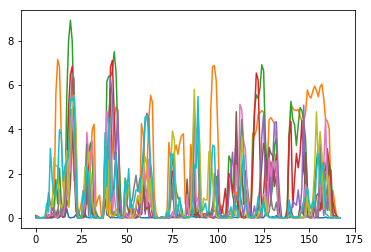

In [712]:
plt.plot(SStest[:100:10,:].T);

In [713]:
# Remove quieter parts when possible #
SSavg = SStest[:40,:].sum(axis=0)   # avg power vs time of low-freq bins
cutoff = (SSavg[4:].mean()/SStest[:2].max()) * 0.66   # self-scale
SStest_on = SStest[:,SSavg > cutoff*SSavg[:2].mean()] # high-pwr time bins

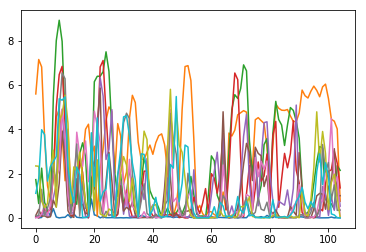

In [715]:
plt.plot(SStest_on[:100:10,:].T);

In [693]:
# Create new NMF model consisting of entire speaker dictionary #
nmf_model2 = NMF(6, solver='mu', beta_loss='kullback-leibler',
        alpha=0, l1_ratio=0, max_iter=400);
nmf_model2.fit(SStest_on.T);
nmf_model2.components_ = D_speakers.T
nmf_model2.n_components_ = D_speakers.T.shape[0]

Wtest = nmf_model2.transform(SStest_on.T)
Vtest = Wtest.T

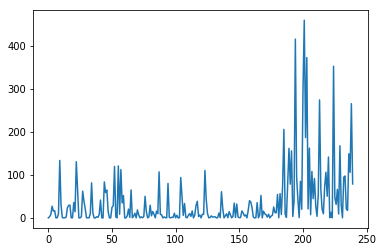

In [694]:
# Sum up the activation components over time #
# The final energy is an intermediate feature vector to be used for classification.
Venergy = Vtest.sum(axis=1)
plt.plot(Venergy);

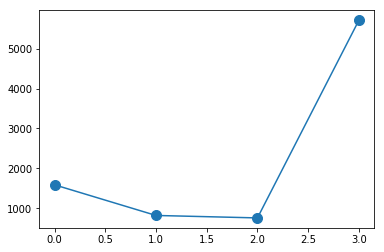

In [696]:
# The final feature vector is created by summing the total energy for each speaker #
# Note for this example that the highest energy, by far, occurs for the 4th speaker (index=3),
# which matches the chosen audio file.
speaker_score = np.empty((nspeaker,1))
for j in range(nspeaker):
    speaker_score[j] = Venergy[speaker_id==j].sum()

plt.plot(speaker_score, 'o-', markersize=10);

### Try out Mel coefficients for NMF training ###

In [725]:
# Convert speaker dictionary to a Mel coefficient version #
# Note, this approach was not fruitful. MFCC have negative values, so I was uncertain
# how to apply them for NMF. Instead I attempted to apply the MFCC to the dictionary
# output of NMF, as seen in the literature.
DM_speakers = librosa.feature.mfcc(S=D_speakers, n_mfcc=12)

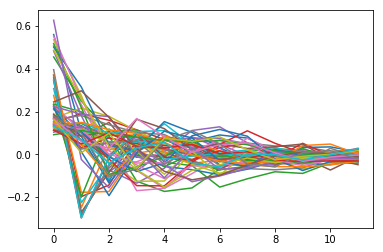

In [751]:
plt.plot(DM_speakers[:,speaker_id==0]);

In [808]:
# Choose a file and calculate test spectrogram #
wavfile = wavTrain[3][3]  # 3,3=good, 3,0=good, 1,3=fair, 1,0=barely,
wavtest, srate = sf.read(wavfile)  # 0,3=fair, 0,0=fair, 2,7=good
freqs, times, SStest = log_spectrogram(wavtest, srate, freq_lim=FREQRANGE)
SStest = SStest + abs(SStest.min())  # size F x T

SSavg = SStest[:40,:].sum(axis=0)   # avg power vs time of low-freq bins
cutoff = (SSavg[4:].mean()/SStest[:2].max()) * 0.66   # self-scale
SStest_on = SStest[:,SSavg > cutoff*SSavg[:2].mean()] # high-pwr time bins

In [810]:
# Pass test spectrogram into full-model NMF #
nmf_model2 = NMF(6, solver='mu', beta_loss='kullback-leibler',
        alpha=0, l1_ratio=0, max_iter=400);
nmf_model2.fit(SStest_on.T);

nmf_model2.components_ = D_speakers.T
nmf_model2.n_components_ = D_speakers.T.shape[0]
Wtest = nmf_model2.transform(SStest_on.T)
Vtest = Wtest.T

Vtest_pinv = np.linalg.pinv(D_speakers).dot(SStest_on)

Vtest_sum = Vtest.sum(axis=0,keepdims=True)
Vtest_sum = np.repeat(Vtest_sum, len(speaker_id), axis=0)
Vtest_norm = Vtest / Vtest_sum

Vtest_mfcc = Vtest_mfcc = np.linalg.pinv(DM_speakers).dot(librosa.feature.mfcc(S=SStest_on, n_mfcc=12))


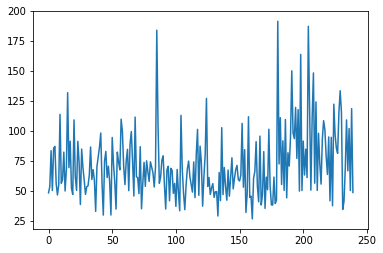

In [819]:
# The MFCC energy vector is noisy #
Venergy_mfcc = abs(Vtest_mfcc).sum(axis=1)
plt.plot(Venergy_mfcc);

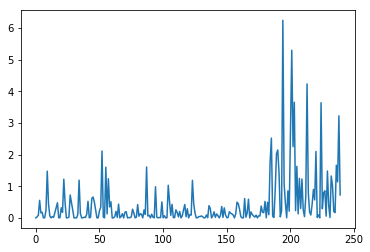

In [790]:
# The regular energy vectors (here and below) are more clean #
Venergy_norm = Vtest_norm.sum(axis=1)
plt.plot(Venergy_norm);

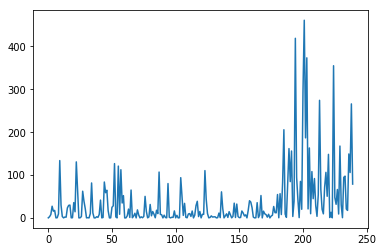

In [820]:
Venergy = Vtest.sum(axis=1)
plt.plot(Venergy);

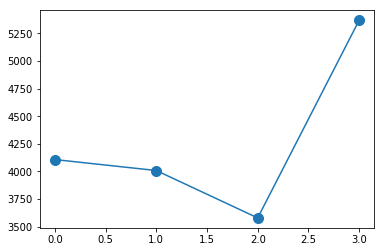

In [822]:
# Even the MFCC version did ok, but it wasn't the best #
speaker_score = np.empty((nspeaker,1))
for j in range(nspeaker):
    speaker_score[j] = Venergy_mfcc[speaker_id==j].sum()

plt.plot(speaker_score, 'o-', markersize=10);

### Repeat examples of speaker prediction after PCA ###
Not good, as PCs group too much. Going with sparsity instead.

In [341]:
from sklearn.decomposition import PCA

In [431]:
np.vstack([np.array([2,3,4],ndmin=2),np.array([6,7,8],ndmin=2)])

array([[2, 3, 4],
       [6, 7, 8]])

In [509]:
pca_func = PCA(n_components=5)
Dpca_speakers = []
for j in range(nspeaker):
    dpca = pca_func.fit_transform(D_speakers[:,speaker_id==j])
    Dpca_speakers.append(dpca)
#     Dpca_speakers.append(dpca + abs(dpca.min()))

Dpca_speakers = np.hstack(Dpca_speakers)

In [505]:
pca_func = PCA(n_components=20)
Dpca_speakers = pca_func.fit_transform(D_speakers)

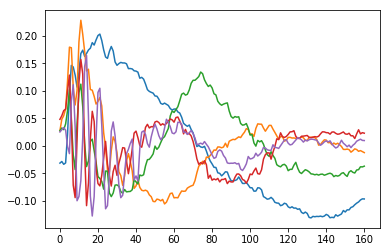

In [510]:
plt.plot(Dpca_speakers[:,0:5]);

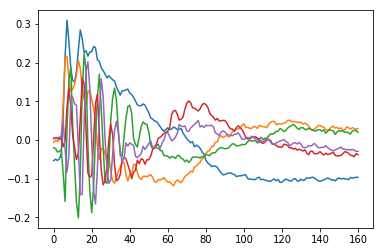

In [511]:
plt.plot(Dpca_speakers[:,5:10]);

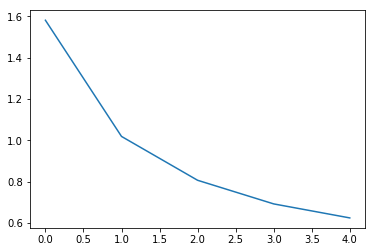

In [512]:
# Look at the distribution of singular values #
pca_svalues = pca_func.singular_values_
plt.plot(pca_svalues);

In [471]:
# Create new NMF model consisting of entire speaker dictionary #
nmf_model3 = NMF(6, solver='mu', beta_loss='kullback-leibler',
        alpha=.2, l1_ratio=.8);
nmf_model3.fit(SStest.T);
nmf_model3.components_ = Dpca_speakers.T
nmf_model3.n_components_ = Dpca_speakers.T.shape[0]

In [521]:
# Choose a file and calculate test spectrogram #
wavfile = wavTrain[3][2]  # 3,3=good, 3,0=good, 1,3=fair, 1,0=barely,
wavtest, srate = sf.read(wavfile)  # 0,3=fair, 0,0=fair, 2,7=good
freqs, times, SStest = log_spectrogram(wavtest, srate, freq_lim=(0,4000))
SStest = SStest + abs(SStest.min())  # size F x T

SSavg = SStest[:40,:].sum(axis=0)
SStest_on = SStest[:,SSavg > 40*SSavg[:2].mean()]

# Wpca = nmf_model3.transform(SStest_on.T)
# Vpca = Wpca.T

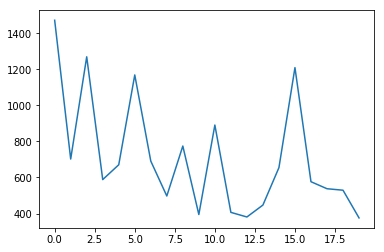

In [522]:
Vpca = np.linalg.pinv(Dpca_speakers).dot(SStest_on)

Venergy = abs(Vpca).sum(axis=1)
plt.plot(Venergy);

In [523]:
speaker_id_pca = [0]*5 + [1]*5 + [2]*5 + [3]*5
speaker_score_pca = np.empty((nspeaker,1))
for j in range(nspeaker):
    speaker_score_pca[j] = Venergy[np.array(speaker_id_pca)==j].sum()

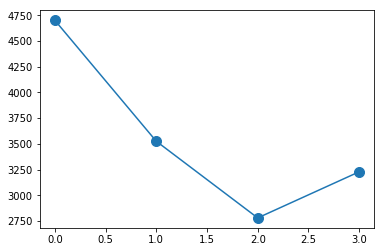

In [524]:
plt.plot(speaker_score_pca, 'o-', markersize=10);

In [475]:
test = np.linalg.pinv(Dpca_speakers)